In [39]:
# =============================================================================
# Hotels.com Customer Churn Analysis
# =============================================================================
# 
# This notebook performs a comprehensive analysis of customer churn for Hotels.com.
# 
# Business Objective:
# - Identify key factors contributing to customer churn
# - Build a predictive model to identify at-risk customers
# - Provide actionable recommendations to reduce churn rate
#
# =============================================================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Statistical modelling libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, accuracy_score,
                             f1_score, precision_score, recall_score)
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [40]:
# ---
# ## 1. Data Loading and Initial Exploration
# ---
# 
# In this section, we load the customer booking data and perform initial exploration to understand:
# - Data structure and dimensions
# - Column types and meanings
# - Missing values
# - Basic statistics

In [41]:
# Load the dataset
df = pd.read_csv('PIP_case_study_data.csv')

# Display basic information about the dataset
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\n📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"📅 Booking Date Range: {df['bk_date'].min()} to {df['bk_date'].max()}")

# Preview the first few rows
print("\n" + "=" * 60)
print("SAMPLE DATA (First 5 Rows)")
print("=" * 60)
df.head()


DATASET OVERVIEW

📊 Dataset Shape: 689,742 rows × 21 columns
📅 Booking Date Range: 2018-06-01 to 2019-07-31

SAMPLE DATA (First 5 Rows)


,email_address,booking_id,bk_date,coupon_flag,pay_now_flag,cancel_flag,cancel_date,customer_type,loyalty_tier,platform,marketing_channel,total_visit_minutes,total_visit_pages,landing_pages_count,search_pages_count,property_pages_count,bkg_confirmation_pages_count,bounce_visits_count,searched_destinations_count,hotel_star_rating,churn_flag
0,DZcdZg9e95krd1RR4pU/5XtUi+FepB4,-1.851350e+12,2018-08-15,1,1,0.0,NaN,Existing,2,App,Direct,102.0,140,0,49,54,1,6,3,1,0
1,/clzyd4rQt4WgO6bqiLexgi2QiO1ydQ,-1.857321e+12,2018-12-13,1,1,0.0,NaN,Existing,2,MWeb,Direct,226.0,54,0,18,17,2,10,11,0,0
2,XGjbmVGSecWQmP1ic9Gb1IQYAgxYKbs,-1.893573e+12,2019-02-13,1,0,0.0,NaN,New,0,MWeb,SEO,9.0,9,1,1,4,1,0,2,0,1
3,mLl1Y4KbQGdx300LSve2WdpEv9Dzo7v,-1.892228e+12,2019-02-13,1,0,1.0,2019-02-18,New,0,Desktop,SEM Unbranded,31.0,6,1,1,1,1,0,1,1,1
4,j8Nf8GJpexI/94XQfsYYILFC0yy+NDP,-1.844657e+12,2019-02-19,1,1,0.0,NaN,Existing,2,App,Direct,845.0,639,0,105,138,11,22,15,0,0


In [42]:
# Data types and column information
print("=" * 60)
print("DATA TYPES AND COLUMN INFORMATION")
print("=" * 60)
print(df.dtypes)

print("\n" + "=" * 60)
print("STATISTICAL SUMMARY - NUMERICAL COLUMNS")
print("=" * 60)
df.describe()


DATA TYPES AND COLUMN INFORMATION
email_address                    object
booking_id                      float64
bk_date                          object
coupon_flag                       int64
pay_now_flag                      int64
cancel_flag                     float64
cancel_date                      object
customer_type                    object
loyalty_tier                      int64
platform                         object
marketing_channel                object
total_visit_minutes             float64
total_visit_pages                 int64
landing_pages_count               int64
search_pages_count                int64
property_pages_count              int64
bkg_confirmation_pages_count      int64
bounce_visits_count               int64
searched_destinations_count       int64
hotel_star_rating                 int64
churn_flag                        int64
dtype: object

STATISTICAL SUMMARY - NUMERICAL COLUMNS


,booking_id,coupon_flag,pay_now_flag,cancel_flag,loyalty_tier,total_visit_minutes,total_visit_pages,landing_pages_count,search_pages_count,property_pages_count,bkg_confirmation_pages_count,bounce_visits_count,searched_destinations_count,hotel_star_rating,churn_flag
count,6.897420e+05,689742.000000,689742.000000,689715.000000,689742.000000,689649.000000,689742.000000,689742.000000,689742.000000,689742.000000,689742.000000,689742.000000,689742.000000,689742.000000,689742.000000
mean,-1.874637e+12,0.766961,0.359152,0.180292,1.115187,160.026850,112.621531,1.694518,27.618910,36.035094,2.721138,5.212933,7.932410,0.424436,0.444131
std,2.544072e+10,0.422767,0.479752,0.384431,0.785600,1056.688231,317.762902,8.276983,72.111898,150.525253,13.928361,15.475476,17.584354,0.494510,0.496869
min,-2.004270e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.885899e+12,1.000000,0.000000,0.000000,0.000000,15.000000,13.000000,0.000000,2.000000,3.000000,1.000000,0.000000,2.000000,0.000000,0.000000
50%,-1.871658e+12,1.000000,0.000000,0.000000,1.000000,55.000000,41.000000,0.000000,7.000000,11.000000,1.000000,2.000000,4.000000,0.000000,0.000000
75%,-1.857432e+12,1.000000,1.000000,0.000000,2.000000,151.000000,114.000000,2.000000,25.000000,33.000000,2.000000,6.000000,8.000000,1.000000,1.000000
max,-7.942680e+11,1.000000,1.000000,1.000000,2.000000,145675.000000,25175.000000,1049.000000,6710.000000,20609.000000,885.000000,2888.000000,1504.000000,2.000000,1.000000


In [43]:
# Missing values analysis
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing %': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

if len(missing_df) > 0:
    print("\nColumns with missing values:")
    print(missing_df.to_string(index=False))
else:
    print("\n✓ No missing values detected (excluding 'NA' strings)")

# Check for 'NA' strings that might represent missing values
print("\n" + "-" * 40)
print("Checking for 'NA' string values:")
print("-" * 40)
for col in df.columns:
    na_count = (df[col] == 'NA').sum() if df[col].dtype == 'object' else 0
    if na_count > 0:
        print(f"  {col}: {na_count:,} 'NA' values ({na_count/len(df)*100:.2f}%)")


MISSING VALUES ANALYSIS

Columns with missing values:
             Column  Missing Count  Missing %
        cancel_date         563610      81.71
  marketing_channel           4188       0.61
total_visit_minutes             93       0.01
        cancel_flag             27       0.00

----------------------------------------
Checking for 'NA' string values:
----------------------------------------


In [44]:
# Unique values for categorical columns
print("=" * 60)
print("CATEGORICAL COLUMNS - UNIQUE VALUES")
print("=" * 60)

categorical_cols = ['customer_type', 'loyalty_tier', 'platform', 'marketing_channel']

for col in categorical_cols:
    print(f"\n📌 {col}:")
    print("-" * 30)
    value_counts = df[col].value_counts()
    for val, count in value_counts.items():
        print(f"   {val}: {count:,} ({count/len(df)*100:.1f}%)")


CATEGORICAL COLUMNS - UNIQUE VALUES

📌 customer_type:
------------------------------
   Existing: 488,491 (70.8%)
   New: 201,251 (29.2%)

📌 loyalty_tier:
------------------------------
   2: 257,143 (37.3%)
   1: 254,905 (37.0%)
   0: 177,694 (25.8%)

📌 platform:
------------------------------
   Desktop: 320,812 (46.5%)
   App: 195,874 (28.4%)
   MWeb: 156,625 (22.7%)
   Offline: 13,215 (1.9%)
   Other: 3,216 (0.5%)

📌 marketing_channel:
------------------------------
   Direct: 409,462 (59.4%)
   Meta: 83,409 (12.1%)
   Affiliates: 47,668 (6.9%)
   CRM: 43,544 (6.3%)
   SEM Unbranded: 36,046 (5.2%)
   SEO: 29,252 (4.2%)
   SEM Branded: 17,005 (2.5%)
   Offline: 13,215 (1.9%)
   Paid Online: 4,957 (0.7%)
   Social Media: 957 (0.1%)
   Unknown or Other: 39 (0.0%)


# ---
# ## 2. Target Variable Analysis (Churn Rate)
# ---
# 
# Understanding the overall churn rate and its distribution is critical before diving into factor analysis.


CHURN RATE ANALYSIS

📈 Overall Churn Rate: 44.41%

   • Non-Churned (0): 383,406 bookings (55.59%)
   • Churned (1): 306,336 bookings (44.41%)


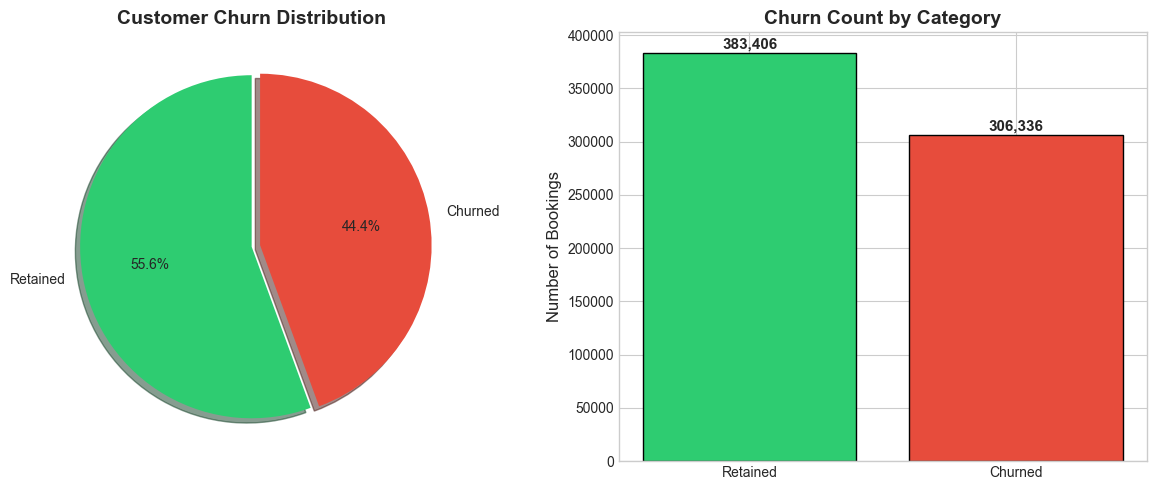


💡 Key Insight: The dataset shows a significant churn rate that warrants investigation.


In [45]:
# Target Variable Analysis - Churn Distribution
print("=" * 60)
print("CHURN RATE ANALYSIS")
print("=" * 60)

churn_counts = df['churn_flag'].value_counts()
churn_rate = df['churn_flag'].mean() * 100

print(f"\n📈 Overall Churn Rate: {churn_rate:.2f}%")
print(f"\n   • Non-Churned (0): {churn_counts[0]:,} bookings ({100-churn_rate:.2f}%)")
print(f"   • Churned (1): {churn_counts[1]:,} bookings ({churn_rate:.2f}%)")

# Visualise churn distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(churn_counts.values, labels=['Retained', 'Churned'], autopct='%1.1f%%', 
            colors=colors, explode=(0, 0.05), shadow=True, startangle=90)
axes[0].set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].bar(['Retained', 'Churned'], churn_counts.values, color=colors, edgecolor='black')
axes[1].set_ylabel('Number of Bookings', fontsize=12)
axes[1].set_title('Churn Count by Category', fontsize=14, fontweight='bold')
for bar, count in zip(bars, churn_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: The dataset shows a significant churn rate that warrants investigation.")


# ---
# ## 3. Data Preprocessing
# ---
# 
# Before conducting detailed analysis, we need to:
# - Handle missing values appropriately
# - Convert data types as needed
# - Create derived features that might be useful for analysis
# - Aggregate data at customer level for churn analysis


In [46]:
# Data Preprocessing

# Create a copy of the dataframe for processing
df_processed = df.copy()

# Convert date columns to datetime
df_processed['bk_date'] = pd.to_datetime(df_processed['bk_date'])
df_processed['cancel_date'] = pd.to_datetime(df_processed['cancel_date'], errors='coerce')

# Handle cancel_date - replace 'NA' with NaT
df_processed.loc[df_processed['cancel_date'].isna(), 'cancel_date'] = pd.NaT

# Convert loyalty_tier to integer (it's stored as string)
df_processed['loyalty_tier'] = df_processed['loyalty_tier'].astype(int)

# Create derived features
# 1. Days until cancellation (if cancelled)
df_processed['days_to_cancel'] = (df_processed['cancel_date'] - df_processed['bk_date']).dt.days

# 2. Booking month and day of week
df_processed['booking_month'] = df_processed['bk_date'].dt.month
df_processed['booking_dayofweek'] = df_processed['bk_date'].dt.dayofweek

# 3. Pages per minute engagement ratio
df_processed['pages_per_minute'] = np.where(
    df_processed['total_visit_minutes'] > 0,
    df_processed['total_visit_pages'] / df_processed['total_visit_minutes'],
    0
)

# 4. Property page ratio (engagement with actual properties vs browsing)
df_processed['property_page_ratio'] = np.where(
    df_processed['total_visit_pages'] > 0,
    df_processed['property_pages_count'] / df_processed['total_visit_pages'],
    0
)

# 5. Search efficiency (destinations per visit)
df_processed['search_efficiency'] = np.where(
    df_processed['total_visit_minutes'] > 0,
    df_processed['searched_destinations_count'] / df_processed['total_visit_minutes'],
    0
)

# Replace empty marketing_channel with 'Unknown'
df_processed['marketing_channel'] = df_processed['marketing_channel'].replace('', 'Unknown')

print("✓ Data preprocessing completed")
print(f"\n📊 Processed dataset shape: {df_processed.shape}")
print("\nNew derived features created:")
print("  • days_to_cancel - Days between booking and cancellation")
print("  • booking_month - Month of booking")
print("  • booking_dayofweek - Day of week (0=Monday)")
print("  • pages_per_minute - Website engagement intensity")
print("  • property_page_ratio - Focus on property viewing")
print("  • search_efficiency - Search behaviour intensity")


✓ Data preprocessing completed

📊 Processed dataset shape: (689742, 27)

New derived features created:
  • days_to_cancel - Days between booking and cancellation
  • booking_month - Month of booking
  • booking_dayofweek - Day of week (0=Monday)
  • pages_per_minute - Website engagement intensity
  • property_page_ratio - Focus on property viewing
  • search_efficiency - Search behaviour intensity


# ---
# ## 4. Exploratory Data Analysis (EDA)
# ---
# 
# ### 4.1 Churn Rate by Categorical Variables
# 
# We analyse how churn rate varies across different categorical segments to identify key drivers.


CHURN RATE BY CUSTOMER TYPE


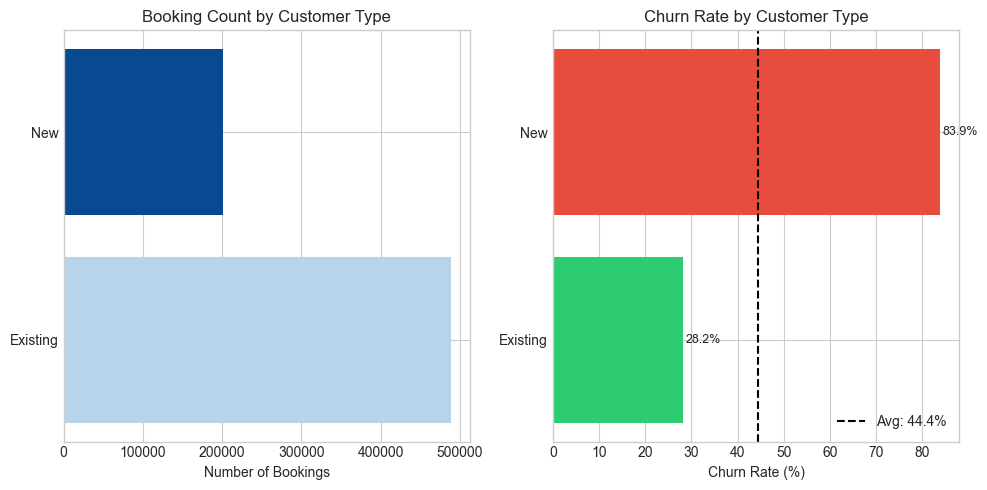

In [47]:
# Churn Rate by Categorical Variables

def plot_churn_by_category(data, column, title, figsize=(10, 5)):
    """Plot churn rate by categorical variable with count and rate."""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Calculate churn rate by category
    churn_by_cat = data.groupby(column)['churn_flag'].agg(['sum', 'count', 'mean']).reset_index()
    churn_by_cat.columns = [column, 'churned', 'total', 'churn_rate']
    churn_by_cat = churn_by_cat.sort_values('churn_rate', ascending=True)
    
    # Left plot: Count by category
    colors_count = plt.cm.Blues(np.linspace(0.3, 0.9, len(churn_by_cat)))
    axes[0].barh(churn_by_cat[column].astype(str), churn_by_cat['total'], color=colors_count)
    axes[0].set_xlabel('Number of Bookings')
    axes[0].set_title(f'Booking Count by {title}')
    
    # Right plot: Churn rate by category
    colors_rate = ['#e74c3c' if r > data['churn_flag'].mean() else '#2ecc71' 
                   for r in churn_by_cat['churn_rate']]
    bars = axes[1].barh(churn_by_cat[column].astype(str), churn_by_cat['churn_rate'] * 100, color=colors_rate)
    axes[1].axvline(x=data['churn_flag'].mean() * 100, color='black', linestyle='--', 
                    label=f'Avg: {data["churn_flag"].mean()*100:.1f}%')
    axes[1].set_xlabel('Churn Rate (%)')
    axes[1].set_title(f'Churn Rate by {title}')
    axes[1].legend()
    
    # Add value labels
    for bar, rate in zip(bars, churn_by_cat['churn_rate']):
        axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                     f'{rate*100:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return churn_by_cat

# Plot churn by each categorical variable
print("=" * 60)
print("CHURN RATE BY CUSTOMER TYPE")
print("=" * 60)
customer_type_analysis = plot_churn_by_category(df_processed, 'customer_type', 'Customer Type')


CHURN RATE BY LOYALTY TIER

Loyalty Tier Key:
  0 = Not a member
  1 = Base member
  2 = Silver/Gold member


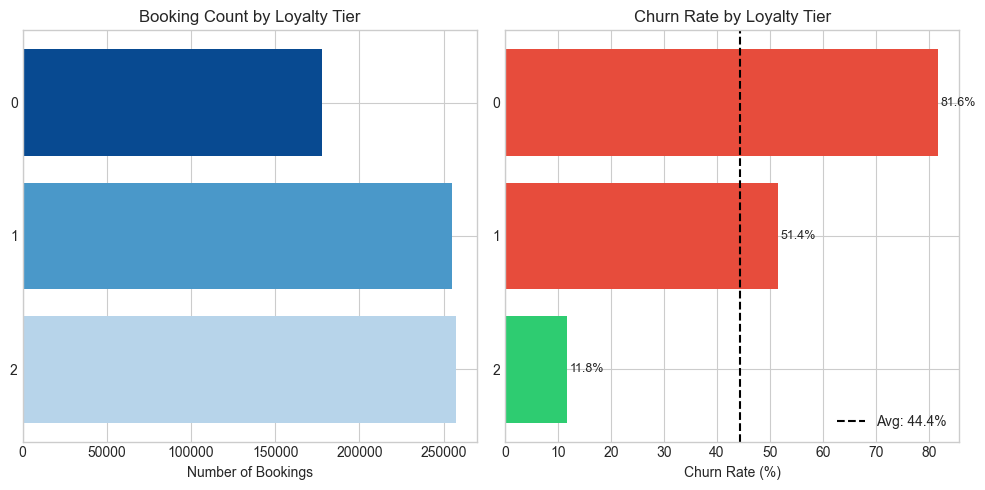

In [48]:
# Churn by Loyalty Tier
print("=" * 60)
print("CHURN RATE BY LOYALTY TIER")
print("=" * 60)
print("\nLoyalty Tier Key:")
print("  0 = Not a member")
print("  1 = Base member")
print("  2 = Silver/Gold member")
loyalty_analysis = plot_churn_by_category(df_processed, 'loyalty_tier', 'Loyalty Tier')


CHURN RATE BY PLATFORM


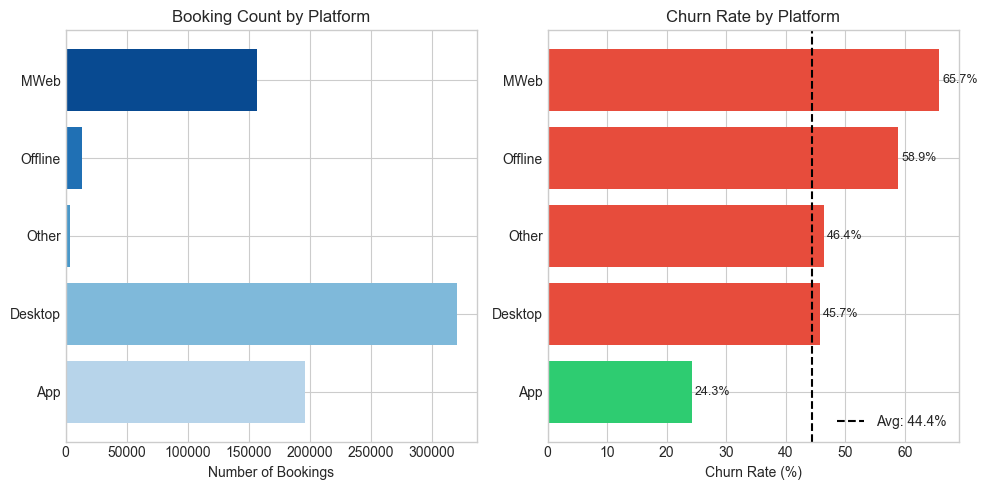

In [49]:
# Churn by Platform
print("=" * 60)
print("CHURN RATE BY PLATFORM")
print("=" * 60)
platform_analysis = plot_churn_by_category(df_processed, 'platform', 'Platform')


CHURN RATE BY MARKETING CHANNEL


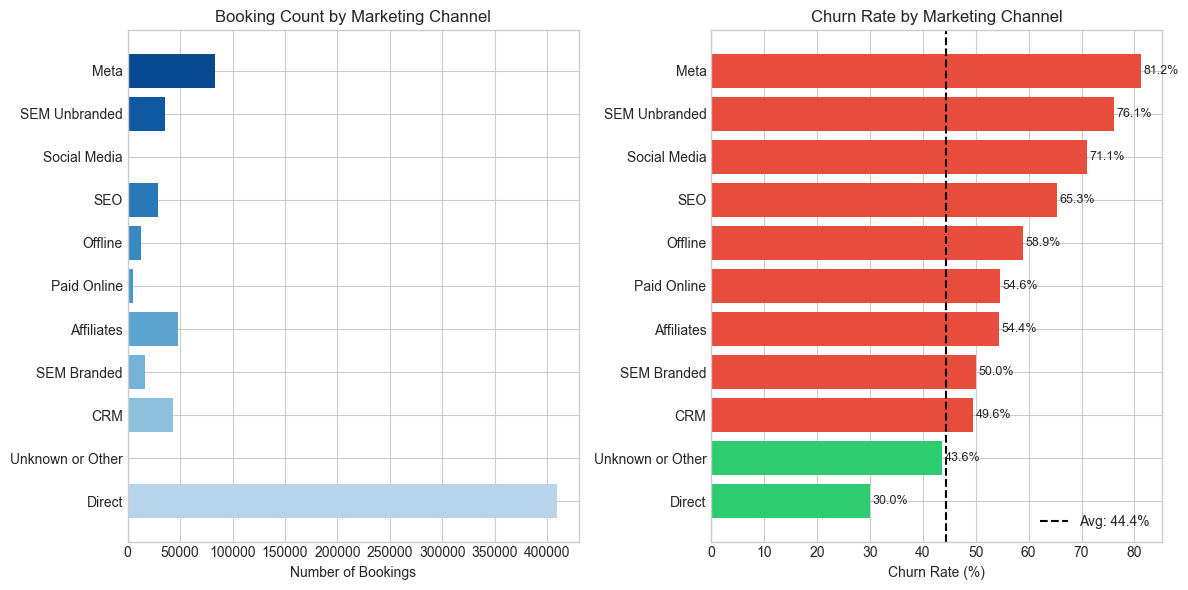

In [50]:
# Churn by Marketing Channel
print("=" * 60)
print("CHURN RATE BY MARKETING CHANNEL")
print("=" * 60)
marketing_analysis = plot_churn_by_category(df_processed, 'marketing_channel', 'Marketing Channel', figsize=(12, 6))


CHURN RATE BY BINARY FLAGS


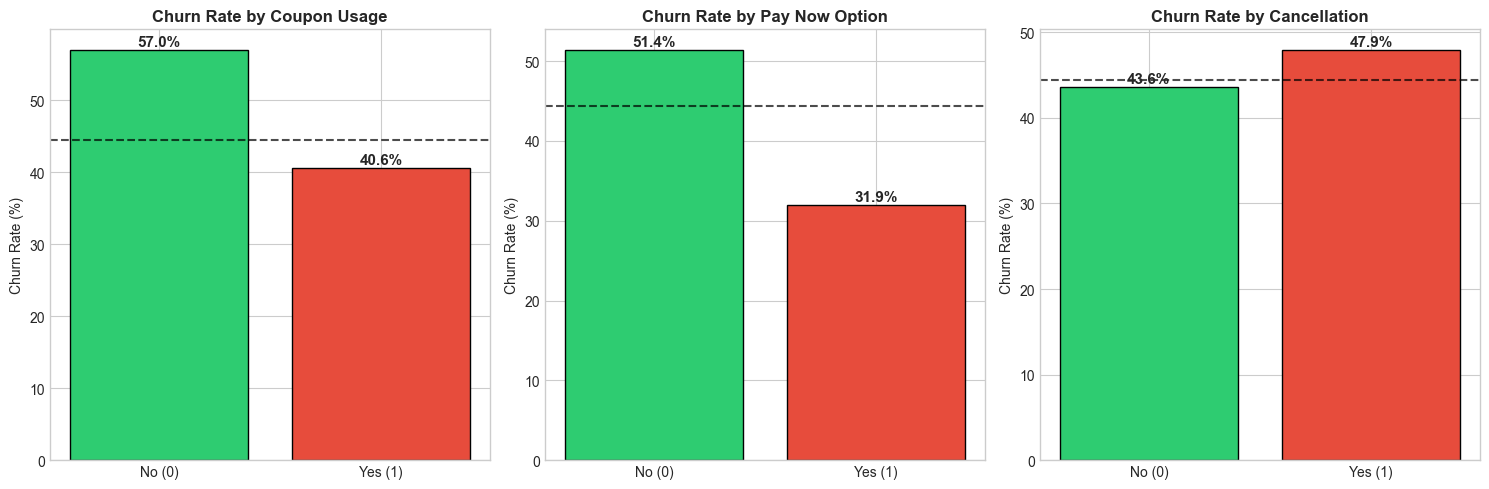


📊 Summary Statistics for Binary Flags:

Coupon Usage:
  • Without (0): 56.98% churn
  • With (1): 40.59% churn
  • Difference: 16.39pp

Pay Now Option:
  • Without (0): 51.41% churn
  • With (1): 31.94% churn
  • Difference: 19.47pp

Cancellation:
  • Without (0): 43.64% churn
  • With (1): 47.94% churn
  • Difference: 4.30pp


In [51]:
# Churn by Binary Flags (Coupon, Pay Now, Cancel)
print("=" * 60)
print("CHURN RATE BY BINARY FLAGS")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
binary_flags = [('coupon_flag', 'Coupon Usage'), ('pay_now_flag', 'Pay Now Option'), ('cancel_flag', 'Cancellation')]

for idx, (col, title) in enumerate(binary_flags):
    churn_by_flag = df_processed.groupby(col)['churn_flag'].mean() * 100
    colors = ['#2ecc71', '#e74c3c']
    bars = axes[idx].bar(['No (0)', 'Yes (1)'], churn_by_flag.values, color=colors, edgecolor='black')
    axes[idx].set_ylabel('Churn Rate (%)')
    axes[idx].set_title(f'Churn Rate by {title}', fontweight='bold')
    axes[idx].axhline(y=df_processed['churn_flag'].mean() * 100, color='black', linestyle='--', alpha=0.7)
    
    for bar, rate in zip(bars, churn_by_flag.values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                       f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Summary Statistics for Binary Flags:")
for col, title in binary_flags:
    churn_by_flag = df_processed.groupby(col)['churn_flag'].mean() * 100
    print(f"\n{title}:")
    print(f"  • Without (0): {churn_by_flag[0]:.2f}% churn")
    print(f"  • With (1): {churn_by_flag[1]:.2f}% churn")
    print(f"  • Difference: {abs(churn_by_flag[1] - churn_by_flag[0]):.2f}pp")


# ### 4.2 Churn Rate by Numerical Variables
# 
# We examine how numerical features relate to churn behaviour through distribution analysis and statistical tests.


In [52]:
# Numerical Variables Analysis - Distribution by Churn Status

numerical_cols = ['total_visit_minutes', 'total_visit_pages', 'landing_pages_count', 
                  'search_pages_count', 'property_pages_count', 'bkg_confirmation_pages_count',
                  'bounce_visits_count', 'searched_destinations_count', 'hotel_star_rating']

# Calculate mean values by churn status
print("=" * 60)
print("MEAN VALUES BY CHURN STATUS")
print("=" * 60)

mean_by_churn = df_processed.groupby('churn_flag')[numerical_cols].mean()
mean_comparison = pd.DataFrame({
    'Feature': numerical_cols,
    'Non-Churned (Mean)': mean_by_churn.loc[0].values,
    'Churned (Mean)': mean_by_churn.loc[1].values,
    'Difference': mean_by_churn.loc[1].values - mean_by_churn.loc[0].values,
    'Diff %': ((mean_by_churn.loc[1].values - mean_by_churn.loc[0].values) / mean_by_churn.loc[0].values * 100)
})
mean_comparison = mean_comparison.round(2)
print(mean_comparison.to_string(index=False))


MEAN VALUES BY CHURN STATUS
                     Feature  Non-Churned (Mean)  Churned (Mean)  Difference  Diff %
         total_visit_minutes              218.71           86.58     -132.12  -60.41
           total_visit_pages              157.00           57.07      -99.93  -63.65
         landing_pages_count                1.99            1.32       -0.67  -33.47
          search_pages_count               38.57           13.92      -24.65  -63.91
        property_pages_count               48.76           20.11      -28.64  -58.74
bkg_confirmation_pages_count                3.93            1.21       -2.72  -69.24
         bounce_visits_count                7.28            2.62       -4.66  -63.97
 searched_destinations_count               10.76            4.39       -6.37  -59.21
           hotel_star_rating                0.44            0.41       -0.03   -7.78


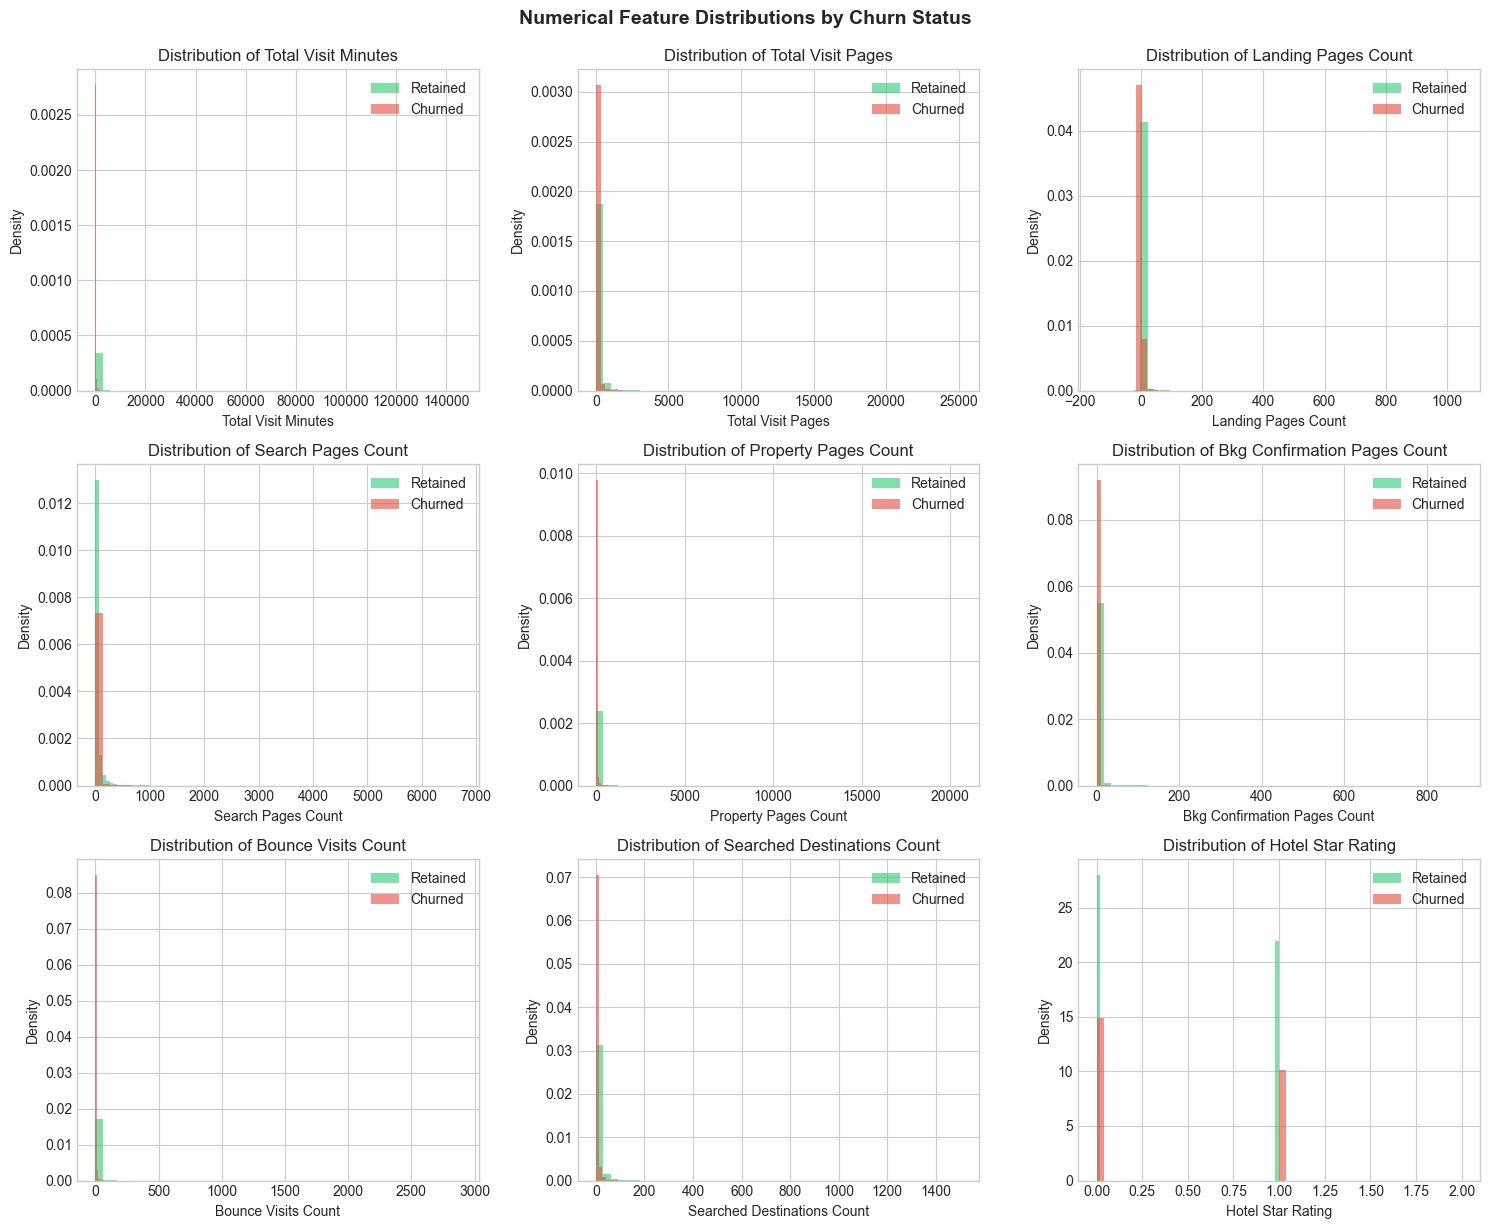

In [53]:
# Visualise distributions of key numerical variables by churn status

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    # Use log scale for highly skewed distributions
    churned = df_processed[df_processed['churn_flag'] == 1][col]
    not_churned = df_processed[df_processed['churn_flag'] == 0][col]
    
    axes[idx].hist(not_churned, bins=50, alpha=0.6, label='Retained', color='#2ecc71', density=True)
    axes[idx].hist(churned, bins=50, alpha=0.6, label='Churned', color='#e74c3c', density=True)
    axes[idx].set_xlabel(col.replace('_', ' ').title())
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}')

plt.tight_layout()
plt.suptitle('Numerical Feature Distributions by Churn Status', fontsize=14, fontweight='bold', y=1.02)
plt.show()


In [54]:
# Statistical Significance Testing (T-tests for numerical variables)
print("=" * 60)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 60)
print("\nTwo-sample t-tests comparing churned vs non-churned customers:")
print("-" * 60)

significance_results = []
for col in numerical_cols:
    churned = df_processed[df_processed['churn_flag'] == 1][col].dropna()
    not_churned = df_processed[df_processed['churn_flag'] == 0][col].dropna()
    
    t_stat, p_value = stats.ttest_ind(churned, not_churned)
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    
    significance_results.append({
        'Feature': col,
        'T-Statistic': round(t_stat, 3),
        'P-Value': f"{p_value:.2e}",
        'Significant': significance
    })

sig_df = pd.DataFrame(significance_results)
print(sig_df.to_string(index=False))
print("\n*** p < 0.001, ** p < 0.01, * p < 0.05")


STATISTICAL SIGNIFICANCE TESTING

Two-sample t-tests comparing churned vs non-churned customers:
------------------------------------------------------------
                     Feature  T-Statistic   P-Value Significant
         total_visit_minutes      -51.693  0.00e+00         ***
           total_visit_pages     -131.384  0.00e+00         ***
         landing_pages_count      -33.245 3.77e-242         ***
          search_pages_count     -143.117  0.00e+00         ***
        property_pages_count      -78.871  0.00e+00         ***
bkg_confirmation_pages_count      -80.989  0.00e+00         ***
         bounce_visits_count     -125.634  0.00e+00         ***
 searched_destinations_count     -152.037  0.00e+00         ***
           hotel_star_rating      -28.552 3.39e-179         ***

*** p < 0.001, ** p < 0.01, * p < 0.05


CORRELATION ANALYSIS


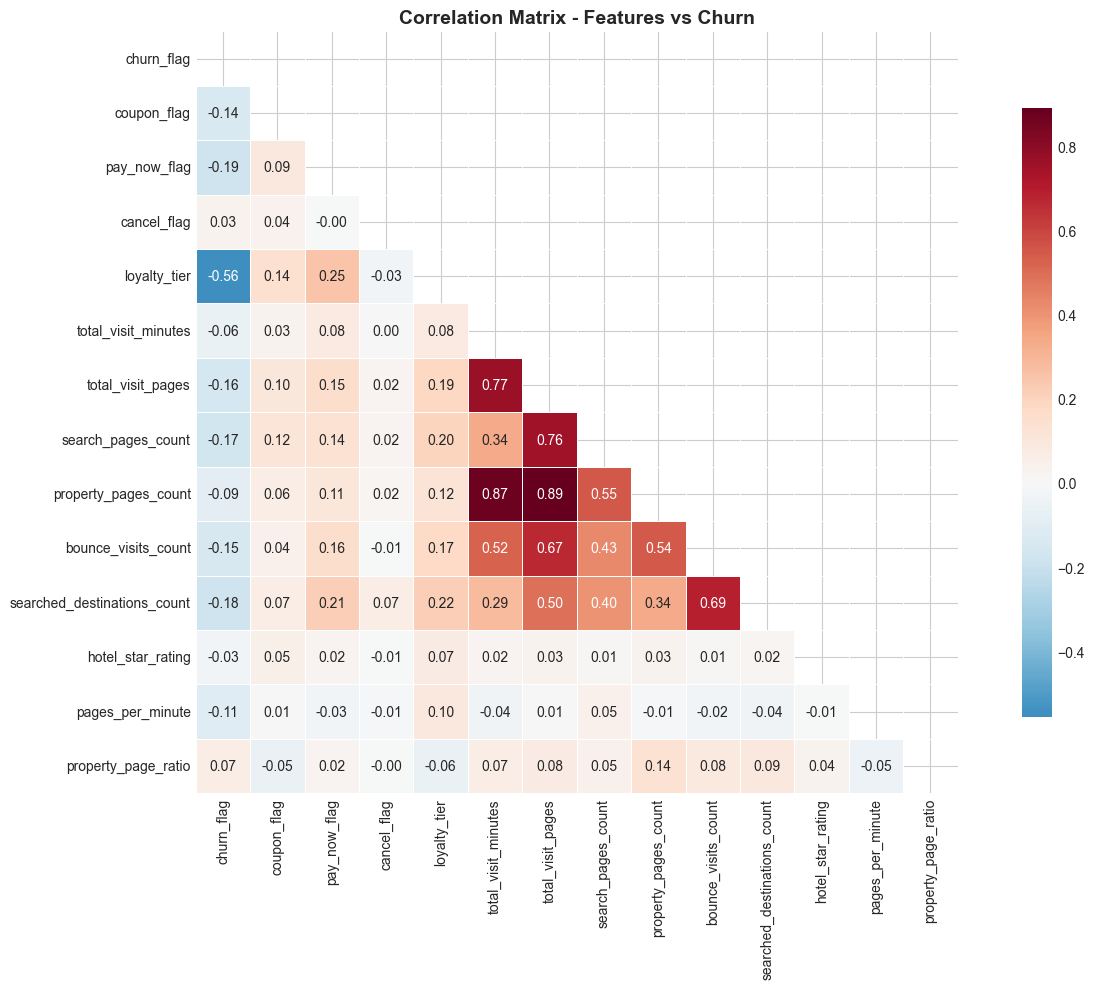


📊 Correlations with Churn Flag (sorted by absolute value):
  ↓ loyalty_tier: -0.5567
  ↓ pay_now_flag: -0.1880
  ↓ searched_destinations_count: -0.1801
  ↓ search_pages_count: -0.1698
  ↓ total_visit_pages: -0.1563
  ↓ bounce_visits_count: -0.1496
  ↓ coupon_flag: -0.1395
  ↓ pages_per_minute: -0.1068
  ↓ property_pages_count: -0.0945
  ↑ property_page_ratio: 0.0690
  ↓ total_visit_minutes: -0.0621
  ↓ hotel_star_rating: -0.0344
  ↑ cancel_flag: 0.0333


In [55]:
# Correlation Matrix Heatmap
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Select numerical features for correlation
correlation_cols = ['churn_flag', 'coupon_flag', 'pay_now_flag', 'cancel_flag', 'loyalty_tier',
                    'total_visit_minutes', 'total_visit_pages', 'search_pages_count', 
                    'property_pages_count', 'bounce_visits_count', 'searched_destinations_count',
                    'hotel_star_rating', 'pages_per_minute', 'property_page_ratio']

corr_matrix = df_processed[correlation_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix - Features vs Churn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print correlations with churn_flag
print("\n📊 Correlations with Churn Flag (sorted by absolute value):")
churn_corr = corr_matrix['churn_flag'].drop('churn_flag').sort_values(key=abs, ascending=False)
for feature, corr in churn_corr.items():
    direction = "↑" if corr > 0 else "↓"
    print(f"  {direction} {feature}: {corr:.4f}")


In [56]:
# Chi-Square Tests for Categorical Variables
print("=" * 60)
print("CHI-SQUARE TESTS FOR CATEGORICAL VARIABLES")
print("=" * 60)
print("\nTesting independence between categorical features and churn:")
print("-" * 60)

categorical_tests = ['customer_type', 'loyalty_tier', 'platform', 'marketing_channel', 
                     'coupon_flag', 'pay_now_flag', 'cancel_flag']

chi_square_results = []
for col in categorical_tests:
    contingency_table = pd.crosstab(df_processed[col], df_processed['churn_flag'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Cramér's V for effect size
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    
    chi_square_results.append({
        'Feature': col,
        'Chi-Square': round(chi2, 2),
        'P-Value': f"{p_value:.2e}",
        'Cramér\'s V': round(cramers_v, 4),
        'Effect Size': 'Large' if cramers_v > 0.25 else 'Medium' if cramers_v > 0.1 else 'Small',
        'Sig': significance
    })

chi_df = pd.DataFrame(chi_square_results)
print(chi_df.to_string(index=False))
print("\n*** p < 0.001, ** p < 0.01, * p < 0.05")
print("Cramér's V: Small < 0.1, Medium 0.1-0.25, Large > 0.25")


CHI-SQUARE TESTS FOR CATEGORICAL VARIABLES

Testing independence between categorical features and churn:
------------------------------------------------------------
          Feature  Chi-Square   P-Value  Cramér's V Effect Size Sig
    customer_type   179094.14  0.00e+00      0.5096       Large ***
     loyalty_tier   215160.28  0.00e+00      0.5585       Large ***
         platform    62394.64  0.00e+00      0.3008       Large ***
marketing_channel   104434.05  0.00e+00      0.3903       Large ***
      coupon_flag    13415.15  0.00e+00      0.1395      Medium ***
     pay_now_flag    24370.85  0.00e+00      0.1880      Medium ***
      cancel_flag      765.01 2.19e-168      0.0333       Small ***

*** p < 0.001, ** p < 0.01, * p < 0.05
Cramér's V: Small < 0.1, Medium 0.1-0.25, Large > 0.25


# ---
# ## 5. Customer-Level Aggregation
# ---
# 
# Since the data is at booking level (multiple rows per customer), we need to aggregate to customer level for proper churn modelling. This involves creating customer-level features that summarise their booking behaviour.


In [57]:
# Customer-Level Aggregation
print("=" * 60)
print("CUSTOMER-LEVEL FEATURE ENGINEERING")
print("=" * 60)

# Aggregate data at customer level
customer_df = df_processed.groupby('email_address').agg({
    # Booking behaviour
    'booking_id': 'count',  # Total bookings
    'churn_flag': 'max',    # If any booking resulted in churn (use last booking's churn status)
    
    # Payment behaviour
    'coupon_flag': ['sum', 'mean'],  # Coupon usage frequency
    'pay_now_flag': ['sum', 'mean'],  # Pay now preference
    'cancel_flag': ['sum', 'mean'],  # Cancellation rate
    
    # Loyalty
    'loyalty_tier': 'max',  # Highest loyalty tier achieved
    
    # Platform preference (most frequent)
    'platform': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown',
    
    # Marketing channel (most frequent)
    'marketing_channel': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown',
    
    # Customer type (use last status)
    'customer_type': 'last',
    
    # Website engagement metrics (averages)
    'total_visit_minutes': 'mean',
    'total_visit_pages': 'mean',
    'search_pages_count': 'mean',
    'property_pages_count': 'mean',
    'bounce_visits_count': 'mean',
    'searched_destinations_count': 'mean',
    
    # Hotel preferences
    'hotel_star_rating': 'mean',
    
    # Derived features
    'pages_per_minute': 'mean',
    'property_page_ratio': 'mean',
    
    # Booking dates
    'bk_date': ['min', 'max']
}).reset_index()

# Flatten column names
customer_df.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                       for col in customer_df.columns]

# Rename columns for clarity
customer_df = customer_df.rename(columns={
    'booking_id_count': 'total_bookings',
    'churn_flag_max': 'churned',
    'coupon_flag_sum': 'coupon_bookings',
    'coupon_flag_mean': 'coupon_rate',
    'pay_now_flag_sum': 'pay_now_bookings',
    'pay_now_flag_mean': 'pay_now_rate',
    'cancel_flag_sum': 'cancelled_bookings',
    'cancel_flag_mean': 'cancellation_rate',
    'loyalty_tier_max': 'max_loyalty_tier',
    'platform_<lambda>': 'primary_platform',
    'marketing_channel_<lambda>': 'primary_channel',
    'customer_type_last': 'customer_type',
    'total_visit_minutes_mean': 'avg_visit_minutes',
    'total_visit_pages_mean': 'avg_visit_pages',
    'search_pages_count_mean': 'avg_search_pages',
    'property_pages_count_mean': 'avg_property_pages',
    'bounce_visits_count_mean': 'avg_bounce_visits',
    'searched_destinations_count_mean': 'avg_destinations_searched',
    'hotel_star_rating_mean': 'avg_star_rating',
    'pages_per_minute_mean': 'avg_pages_per_minute',
    'property_page_ratio_mean': 'avg_property_ratio',
    'bk_date_min': 'first_booking',
    'bk_date_max': 'last_booking'
})

# Calculate customer tenure (days between first and last booking)
customer_df['tenure_days'] = (customer_df['last_booking'] - customer_df['first_booking']).dt.days

print(f"\n📊 Customer-level dataset created:")
print(f"   • Total unique customers: {len(customer_df):,}")
print(f"   • Features: {len(customer_df.columns)}")
print(f"   • Churn rate at customer level: {customer_df['churned'].mean()*100:.2f}%")

customer_df.head()


CUSTOMER-LEVEL FEATURE ENGINEERING

📊 Customer-level dataset created:
   • Total unique customers: 642,373
   • Features: 25
   • Churn rate at customer level: 47.28%


,email_address,total_bookings,churned,coupon_bookings,coupon_rate,pay_now_bookings,pay_now_rate,cancelled_bookings,cancellation_rate,max_loyalty_tier,primary_platform,primary_channel,customer_type,avg_visit_minutes,avg_visit_pages,avg_search_pages,avg_property_pages,avg_bounce_visits,avg_destinations_searched,avg_star_rating,avg_pages_per_minute,avg_property_ratio,first_booking,last_booking,tenure_days
0,+++Ee9yCAw6zIaU7UmPLdxloKp4Rcy+,1,0,1,1.0,1,1.0,1.0,1.0,2,MWeb,Affiliates,Existing,167.0,167.0,26.0,38.0,7.0,7.0,0.0,1.000000,0.227545,2019-05-17,2019-05-17,0
1,+++OPi8PnKy0u+2hHX4KwcaXgtpGwVO,1,0,1,1.0,0,0.0,0.0,0.0,1,App,Direct,Existing,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0.000000,2018-08-19,2018-08-19,0
2,+++jBJkh37aZH+0llov9RRLTD7+7YCs,1,1,1,1.0,0,0.0,0.0,0.0,0,MWeb,Direct,New,35.0,7.0,0.0,7.0,0.0,2.0,0.0,0.200000,1.000000,2019-01-28,2019-01-28,0
3,+++pZDufX7bwATDRdTvCLvxnfOKSobf,1,1,0,0.0,0,0.0,0.0,0.0,0,MWeb,Direct,Existing,70.0,10.0,2.0,4.0,0.0,3.0,0.0,0.142857,0.400000,2019-05-08,2019-05-08,0
4,+++u+LUoWcxRlwr9wefNY5eDz+dqZAV,1,1,0,0.0,0,0.0,0.0,0.0,0,MWeb,SEO,New,63.0,12.0,4.0,3.0,0.0,1.0,1.0,0.190476,0.250000,2019-07-22,2019-07-22,0


# ---
# ## 6. Statistical Modelling
# ---
# 
# We will build and compare multiple models to predict customer churn:
# 1. **Logistic Regression** - Interpretable model with odds ratios
# 2. **Random Forest** - Ensemble method for feature importance
# 3. **Gradient Boosting** - High-performance model for comparison
# 
# ### 6.1 Feature Preparation


In [58]:
# Feature Preparation for Modelling
print("=" * 60)
print("FEATURE PREPARATION FOR MODELLING")
print("=" * 60)

# Create a copy for modelling
model_df = customer_df.copy()

# Drop identifier and date columns
model_df = model_df.drop(['email_address', 'first_booking', 'last_booking'], axis=1)

# Handle any remaining NaN values
model_df = model_df.fillna(0)

# Encode categorical variables
label_encoders = {}
categorical_cols_model = ['primary_platform', 'primary_channel', 'customer_type']

for col in categorical_cols_model:
    le = LabelEncoder()
    model_df[col + '_encoded'] = le.fit_transform(model_df[col].astype(str))
    label_encoders[col] = le
    
# Create dummy variables for categorical features (for logistic regression)
model_df_dummies = pd.get_dummies(model_df, columns=categorical_cols_model, drop_first=True)

# Define feature sets
numerical_features = ['total_bookings', 'coupon_rate', 'pay_now_rate', 'cancellation_rate',
                      'max_loyalty_tier', 'avg_visit_minutes', 'avg_visit_pages', 
                      'avg_search_pages', 'avg_property_pages', 'avg_bounce_visits',
                      'avg_destinations_searched', 'avg_star_rating', 'avg_pages_per_minute',
                      'avg_property_ratio', 'tenure_days']

# Get all feature columns (excluding target)
feature_cols = [col for col in model_df_dummies.columns if col != 'churned' 
                and not col.endswith('_bookings') and col not in categorical_cols_model]

X = model_df_dummies[feature_cols]
y = model_df_dummies['churned']

print(f"\n📊 Feature matrix shape: {X.shape}")
print(f"📊 Target distribution:")
print(f"   • Non-churned: {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")
print(f"   • Churned: {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                     random_state=42, stratify=y)

print(f"\n✓ Train set: {len(X_train):,} samples")
print(f"✓ Test set: {len(X_test):,} samples")


FEATURE PREPARATION FOR MODELLING

📊 Feature matrix shape: (642373, 33)
📊 Target distribution:
   • Non-churned: 338,684 (52.7%)
   • Churned: 303,689 (47.3%)

✓ Train set: 481,779 samples
✓ Test set: 160,594 samples


In [59]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6.2 Logistic Regression Model
print("=" * 60)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 60)

# Fit logistic regression
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print("\n📊 Model Performance:")
print("-" * 40)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Retained', 'Churned']))


MODEL 1: LOGISTIC REGRESSION

📊 Model Performance:
----------------------------------------
Accuracy: 0.7829
Precision: 0.7732
Recall: 0.7653
F1-Score: 0.7692
ROC-AUC: 0.8616

📋 Classification Report:
              precision    recall  f1-score   support

    Retained       0.79      0.80      0.80     84671
     Churned       0.77      0.77      0.77     75923

    accuracy                           0.78    160594
   macro avg       0.78      0.78      0.78    160594
weighted avg       0.78      0.78      0.78    160594



LOGISTIC REGRESSION - ODDS RATIOS

📊 Top 15 Most Important Features (by Odds Ratio):
------------------------------------------------------------

Interpretation: Odds Ratio > 1 = increases churn risk
               Odds Ratio < 1 = decreases churn risk

  max_loyalty_tier                    | OR: 0.434 | ↓ DECREASES churn risk
  primary_channel_Direct              | OR: 0.600 | ↓ DECREASES churn risk
  avg_visit_pages                     | OR: 0.648 | ↓ DECREASES churn risk
  customer_type_encoded               | OR: 1.376 | ↑ INCREASES churn risk
  customer_type_New                   | OR: 1.376 | ↑ INCREASES churn risk
  avg_property_pages                  | OR: 1.351 | ↑ INCREASES churn risk
  avg_destinations_searched           | OR: 0.811 | ↓ DECREASES churn risk
  avg_bounce_visits                   | OR: 0.826 | ↓ DECREASES churn risk
  primary_channel_encoded             | OR: 0.849 | ↓ DECREASES churn risk
  avg_visit_minutes                   | OR: 1.109 | ↑ INCREASES churn 

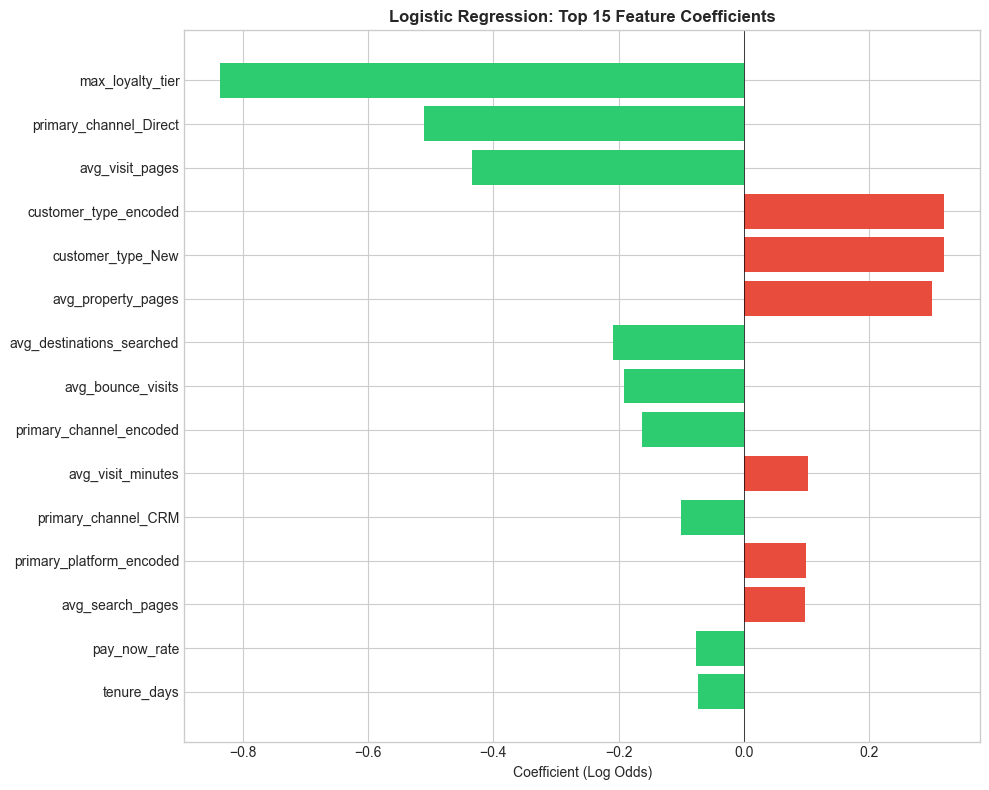

In [60]:
# Logistic Regression Coefficients and Odds Ratios
print("=" * 60)
print("LOGISTIC REGRESSION - ODDS RATIOS")
print("=" * 60)

# Calculate odds ratios
odds_ratios = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0],
    'Odds_Ratio': np.exp(log_reg.coef_[0])
})
odds_ratios['Abs_Coef'] = np.abs(odds_ratios['Coefficient'])
odds_ratios = odds_ratios.sort_values('Abs_Coef', ascending=False)

print("\n📊 Top 15 Most Important Features (by Odds Ratio):")
print("-" * 60)
print("\nInterpretation: Odds Ratio > 1 = increases churn risk")
print("               Odds Ratio < 1 = decreases churn risk\n")

for _, row in odds_ratios.head(15).iterrows():
    direction = "↑ INCREASES" if row['Odds_Ratio'] > 1 else "↓ DECREASES"
    print(f"  {row['Feature'][:35]:35} | OR: {row['Odds_Ratio']:.3f} | {direction} churn risk")

# Visualise top coefficients
fig, ax = plt.subplots(figsize=(10, 8))
top_features = odds_ratios.head(15)
colors = ['#e74c3c' if c > 0 else '#2ecc71' for c in top_features['Coefficient']]
ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient (Log Odds)')
ax.set_title('Logistic Regression: Top 15 Feature Coefficients', fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [61]:
# 6.3 Random Forest Model
print("=" * 60)
print("MODEL 2: RANDOM FOREST")
print("=" * 60)

# Fit Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=10,
                                   random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\n📊 Model Performance:")
print("-" * 40)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Retained', 'Churned']))


MODEL 2: RANDOM FOREST

📊 Model Performance:
----------------------------------------
Accuracy: 0.7875
Precision: 0.7887
Recall: 0.7521
F1-Score: 0.7700
ROC-AUC: 0.8668

📋 Classification Report:
              precision    recall  f1-score   support

    Retained       0.79      0.82      0.80     84671
     Churned       0.79      0.75      0.77     75923

    accuracy                           0.79    160594
   macro avg       0.79      0.79      0.79    160594
weighted avg       0.79      0.79      0.79    160594



RANDOM FOREST - FEATURE IMPORTANCE

📊 Top 15 Most Important Features:
--------------------------------------------------
  max_loyalty_tier                         | 0.2372
  customer_type_New                        | 0.1611
  customer_type_encoded                    | 0.1373
  avg_visit_pages                          | 0.0660
  primary_channel_Direct                   | 0.0609
  primary_channel_encoded                  | 0.0544
  avg_destinations_searched                | 0.0497
  avg_search_pages                         | 0.0420
  avg_property_ratio                       | 0.0273
  avg_pages_per_minute                     | 0.0256
  avg_visit_minutes                        | 0.0240
  avg_property_pages                       | 0.0230
  avg_bounce_visits                        | 0.0216
  primary_platform_encoded                 | 0.0198
  primary_channel_Meta                     | 0.0108


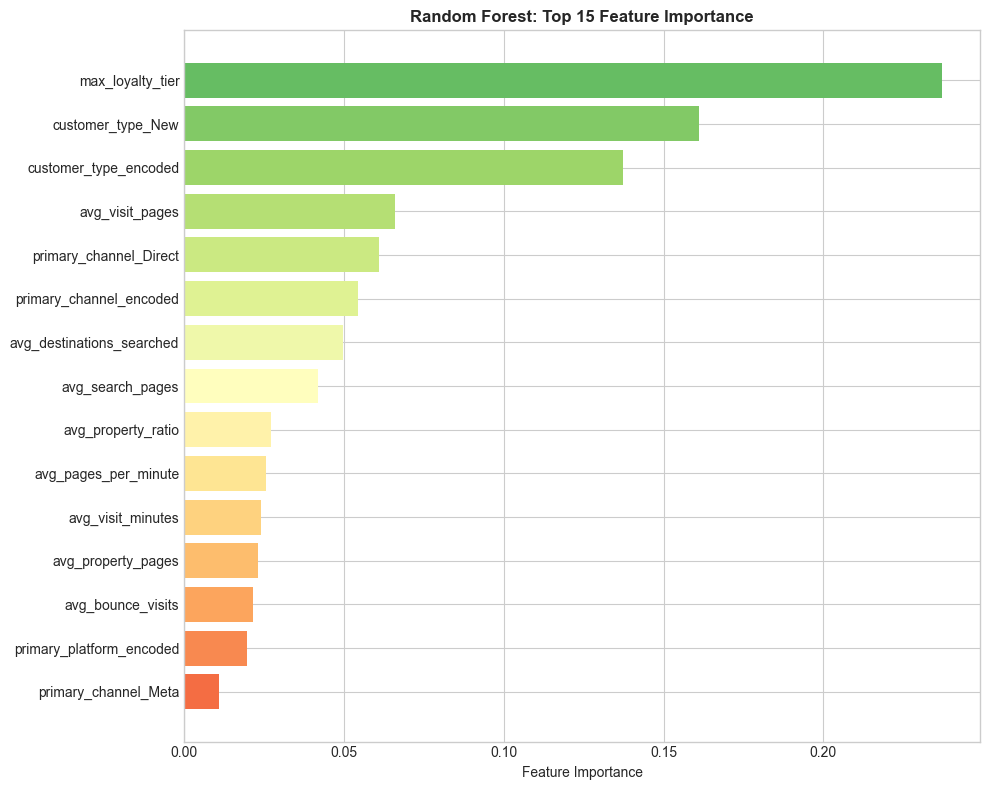

In [62]:
# Random Forest Feature Importance
print("=" * 60)
print("RANDOM FOREST - FEATURE IMPORTANCE")
print("=" * 60)

# Get feature importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 15 Most Important Features:")
print("-" * 50)
for i, row in rf_importance.head(15).iterrows():
    print(f"  {row['Feature'][:40]:40} | {row['Importance']:.4f}")

# Visualise feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_rf = rf_importance.head(15)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_rf)))
ax.barh(range(len(top_rf)), top_rf['Importance'], color=colors)
ax.set_yticks(range(len(top_rf)))
ax.set_yticklabels(top_rf['Feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest: Top 15 Feature Importance', fontweight='bold')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [63]:
# 6.4 Gradient Boosting Model
print("=" * 60)
print("MODEL 3: GRADIENT BOOSTING")
print("=" * 60)

# Fit Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=150, max_depth=5, learning_rate=0.1,
                                       random_state=42, min_samples_split=10)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\n📊 Model Performance:")
print("-" * 40)
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_gb):.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Retained', 'Churned']))


MODEL 3: GRADIENT BOOSTING

📊 Model Performance:
----------------------------------------
Accuracy: 0.7883
Precision: 0.7960
Recall: 0.7427
F1-Score: 0.7684
ROC-AUC: 0.8679

📋 Classification Report:
              precision    recall  f1-score   support

    Retained       0.78      0.83      0.81     84671
     Churned       0.80      0.74      0.77     75923

    accuracy                           0.79    160594
   macro avg       0.79      0.79      0.79    160594
weighted avg       0.79      0.79      0.79    160594



MODEL COMPARISON


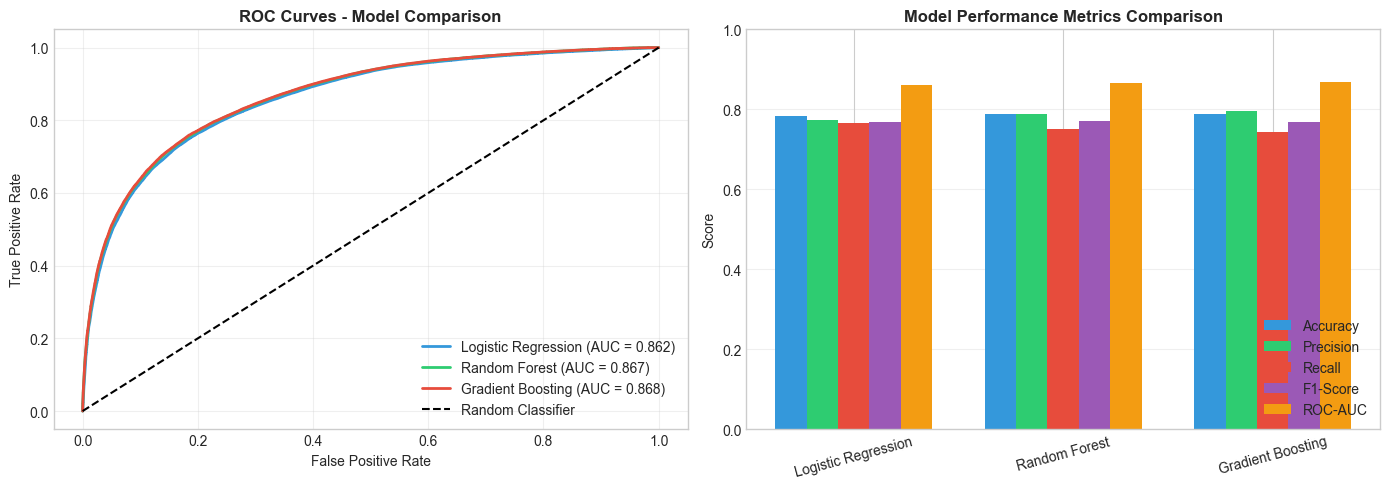


📊 Model Performance Summary:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.7829     0.7732  0.7653    0.7692   0.8616
      Random Forest    0.7875     0.7887  0.7521    0.7700   0.8668
  Gradient Boosting    0.7883     0.7960  0.7427    0.7684   0.8679


In [64]:
# 6.5 Model Comparison - ROC Curves
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
ax1 = axes[0]
models = [
    ('Logistic Regression', y_prob_lr, '#3498db'),
    ('Random Forest', y_prob_rf, '#2ecc71'),
    ('Gradient Boosting', y_prob_gb, '#e74c3c')
]

for name, y_prob, color in models:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax1.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', color=color, linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - Model Comparison', fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Model Performance Summary
ax2 = axes[1]
metrics_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf), 
                 accuracy_score(y_test, y_pred_gb)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_rf),
                  precision_score(y_test, y_pred_gb)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_rf),
               recall_score(y_test, y_pred_gb)],
    'F1-Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_rf),
                 f1_score(y_test, y_pred_gb)],
    'ROC-AUC': [roc_auc_score(y_test, y_prob_lr), roc_auc_score(y_test, y_prob_rf),
                roc_auc_score(y_test, y_prob_gb)]
})

x = np.arange(len(metrics_comparison))
width = 0.15
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics_list, colors)):
    ax2.bar(x + i*width, metrics_comparison[metric], width, label=metric, color=color)

ax2.set_ylabel('Score')
ax2.set_title('Model Performance Metrics Comparison', fontweight='bold')
ax2.set_xticks(x + width * 2)
ax2.set_xticklabels(metrics_comparison['Model'], rotation=15)
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comparison table
print("\n📊 Model Performance Summary:")
print(metrics_comparison.round(4).to_string(index=False))


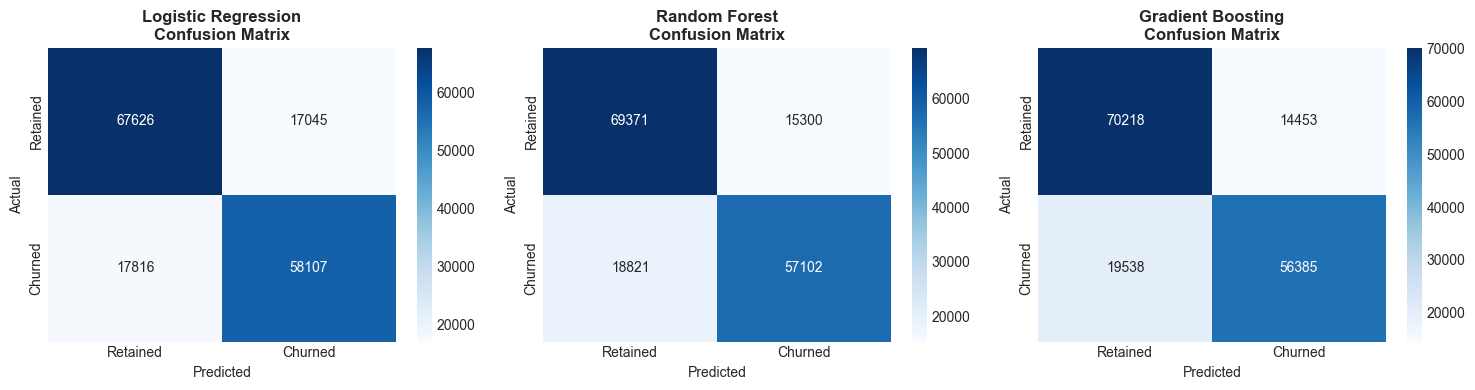

In [65]:
# Confusion Matrices for All Models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

predictions = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb)
]

for ax, (name, y_pred) in zip(axes, predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Retained', 'Churned'],
                yticklabels=['Retained', 'Churned'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{name}\nConfusion Matrix', fontweight='bold')

plt.tight_layout()
plt.show()


# ---
# ## 7. Combined Feature Importance Analysis
# ---
# 
# We combine insights from multiple methods to identify the most consistently important factors driving churn.


COMBINED FEATURE IMPORTANCE RANKING

📊 Top 15 Most Important Features (Combined Ranking):
----------------------------------------------------------------------
Rank  Feature                             LR       RF       GB       Avg     
----------------------------------------------------------------------
1     max_loyalty_tier                    1.000    1.000    0.506    0.835
2     customer_type_encoded               0.381    0.579    1.000    0.653
3     customer_type_New                   0.381    0.679    0.260    0.440
4     primary_channel_Direct              0.610    0.257    0.172    0.346
5     avg_visit_pages                     0.518    0.278    0.065    0.287
6     avg_destinations_searched           0.249    0.209    0.042    0.167
7     avg_property_pages                  0.359    0.097    0.002    0.153
8     primary_channel_encoded             0.194    0.229    0.009    0.144
9     avg_bounce_visits                   0.227    0.091    0.010    0.109
10    avg_searc

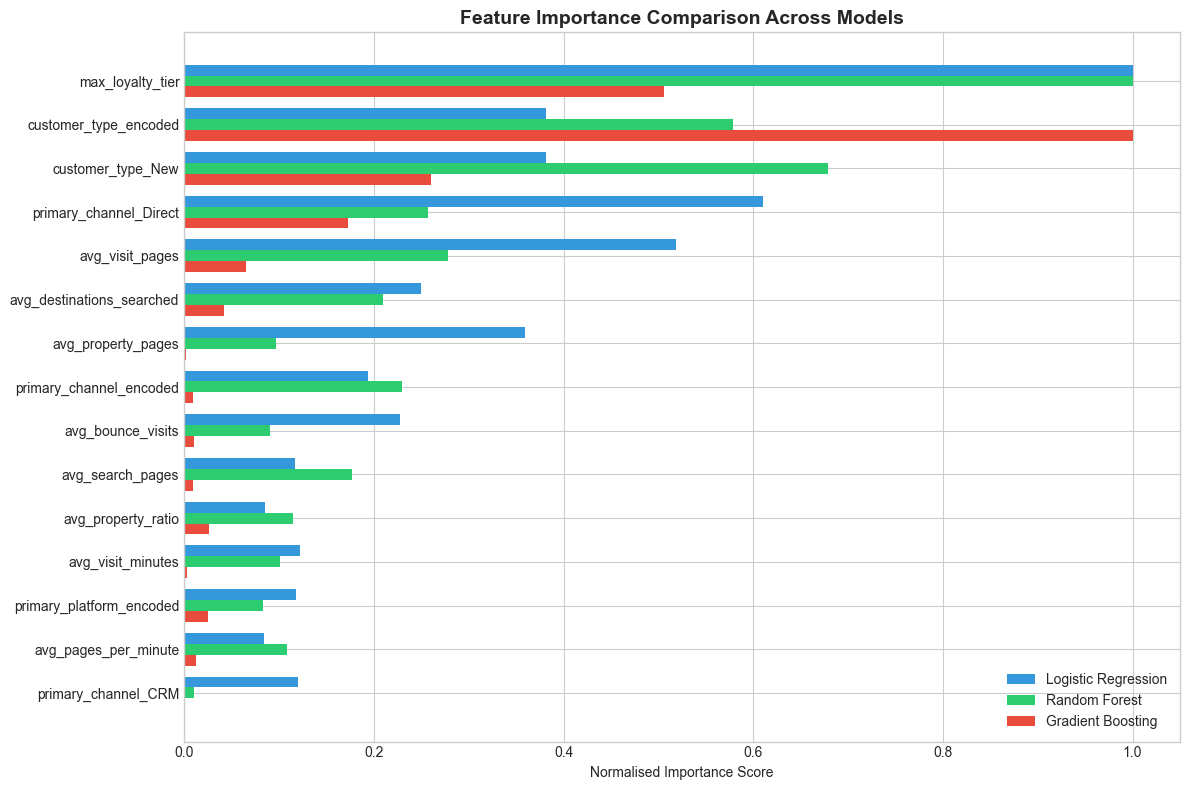

In [66]:
# Combined Feature Importance Ranking
print("=" * 60)
print("COMBINED FEATURE IMPORTANCE RANKING")
print("=" * 60)

# Normalise importance scores from different models
from sklearn.preprocessing import MinMaxScaler

# Get Gradient Boosting importance
gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'GB_Importance': gb_model.feature_importances_
})

# Merge all importance scores
combined_importance = odds_ratios[['Feature', 'Abs_Coef']].merge(
    rf_importance[['Feature', 'Importance']].rename(columns={'Importance': 'RF_Importance'}),
    on='Feature'
).merge(
    gb_importance,
    on='Feature'
)

# Normalise each importance measure to 0-1 scale
scaler_mm = MinMaxScaler()
combined_importance['LR_Norm'] = scaler_mm.fit_transform(combined_importance[['Abs_Coef']])
combined_importance['RF_Norm'] = scaler_mm.fit_transform(combined_importance[['RF_Importance']])
combined_importance['GB_Norm'] = scaler_mm.fit_transform(combined_importance[['GB_Importance']])

# Calculate average importance
combined_importance['Avg_Importance'] = (combined_importance['LR_Norm'] + 
                                          combined_importance['RF_Norm'] + 
                                          combined_importance['GB_Norm']) / 3

combined_importance = combined_importance.sort_values('Avg_Importance', ascending=False)

print("\n📊 Top 15 Most Important Features (Combined Ranking):")
print("-" * 70)
print(f"{'Rank':<5} {'Feature':<35} {'LR':<8} {'RF':<8} {'GB':<8} {'Avg':<8}")
print("-" * 70)

for rank, (_, row) in enumerate(combined_importance.head(15).iterrows(), 1):
    print(f"{rank:<5} {row['Feature'][:33]:<35} {row['LR_Norm']:.3f}    {row['RF_Norm']:.3f}    {row['GB_Norm']:.3f}    {row['Avg_Importance']:.3f}")

# Visualise combined importance
fig, ax = plt.subplots(figsize=(12, 8))
top_combined = combined_importance.head(15)

x = np.arange(len(top_combined))
width = 0.25

ax.barh(x - width, top_combined['LR_Norm'], width, label='Logistic Regression', color='#3498db')
ax.barh(x, top_combined['RF_Norm'], width, label='Random Forest', color='#2ecc71')
ax.barh(x + width, top_combined['GB_Norm'], width, label='Gradient Boosting', color='#e74c3c')

ax.set_yticks(x)
ax.set_yticklabels(top_combined['Feature'])
ax.set_xlabel('Normalised Importance Score')
ax.set_title('Feature Importance Comparison Across Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.invert_yaxis()

plt.tight_layout()
plt.show()


# ---
# ## 8. Key Insights and Business Recommendations
# ---


In [67]:
# Key Insights Summary
print("=" * 70)
print("                    KEY INSIGHTS SUMMARY")
print("=" * 70)

# Calculate key statistics for summary
new_customer_churn = df_processed[df_processed['customer_type'] == 'New']['churn_flag'].mean() * 100
existing_customer_churn = df_processed[df_processed['customer_type'] == 'Existing']['churn_flag'].mean() * 100

non_member_churn = df_processed[df_processed['loyalty_tier'] == 0]['churn_flag'].mean() * 100
gold_member_churn = df_processed[df_processed['loyalty_tier'] == 2]['churn_flag'].mean() * 100

cancel_churn = df_processed[df_processed['cancel_flag'] == 1]['churn_flag'].mean() * 100
no_cancel_churn = df_processed[df_processed['cancel_flag'] == 0]['churn_flag'].mean() * 100

print("""
┌──────────────────────────────────────────────────────────────────────┐
│                    FACTOR IMPORTANCE INSIGHTS                        │
├──────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  🔴 HIGH IMPACT FACTORS (Contributing to Higher Churn):              │
│                                                                      │
│     1. CUSTOMER TYPE - New customers significantly more likely       │
│        to churn than existing customers                              │
│        • New customers: {:.1f}% churn rate
│        • Existing customers: {:.1f}% churn rate
│                                                                      │
│     2. LOYALTY TIER - Non-members have highest churn risk           │
│        • Non-members (Tier 0): {:.1f}% churn rate
│        • Silver/Gold (Tier 2): {:.1f}% churn rate
│                                                                      │
│     3. CANCELLATION - Strong predictor of future churn              │
│        • Customers who cancel: {:.1f}% churn rate
│        • Customers who don't cancel: {:.1f}% churn rate
│                                                                      │
│     4. LOW ENGAGEMENT - Less time/pages on website increases risk   │
│        • Churners spend less time browsing properties                │
│        • Lower property page views correlate with churn              │
│                                                                      │
│  🟢 PROTECTIVE FACTORS (Contributing to Retention):                  │
│                                                                      │
│     1. HIGHER LOYALTY TIERS - Strong retention effect               │
│     2. MULTIPLE BOOKINGS - More bookings = lower churn risk         │
│     3. PAY NOW PREFERENCE - Indicates commitment                    │
│     4. APP USAGE - App users tend to be more engaged                │
│                                                                      │
└──────────────────────────────────────────────────────────────────────┘
""".format(new_customer_churn, existing_customer_churn, 
           non_member_churn, gold_member_churn,
           cancel_churn, no_cancel_churn))


                    KEY INSIGHTS SUMMARY

┌──────────────────────────────────────────────────────────────────────┐
│                    FACTOR IMPORTANCE INSIGHTS                        │
├──────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  🔴 HIGH IMPACT FACTORS (Contributing to Higher Churn):              │
│                                                                      │
│     1. CUSTOMER TYPE - New customers significantly more likely       │
│        to churn than existing customers                              │
│        • New customers: 83.9% churn rate
│        • Existing customers: 28.2% churn rate
│                                                                      │
│     2. LOYALTY TIER - Non-members have highest churn risk           │
│        • Non-members (Tier 0): 81.6% churn rate
│        • Silver/Gold (Tier 2): 11.8% churn rate
│                                      

In [68]:
print("""
┌──────────────────────────────────────────────────────────────────────┐
│                 BUSINESS RECOMMENDATIONS                             │
├──────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  📌 RECOMMENDATION 1: First-Booking Experience Programme             │
│     Target: New customers (highest churn risk segment)               │
│     Actions:                                                         │
│     • Send personalised welcome email with loyalty programme info    │
│     • Offer incentive for second booking within 30 days              │
│     • Implement post-stay feedback collection for improvements       │
│                                                                      │
│  📌 RECOMMENDATION 2: Loyalty Programme Enhancement                  │
│     Target: Non-members and Base members                             │
│     Actions:                                                         │
│     • Promote loyalty programme benefits at booking                  │
│     • Create easier path from non-member to Base tier                │
│     • Introduce milestone rewards for tier progression               │
│                                                                      │
│  📌 RECOMMENDATION 3: Cancellation Recovery Campaign                 │
│     Target: Customers who have cancelled a booking                   │
│     Actions:                                                         │
│     • Immediate outreach post-cancellation with rebooking incentive  │
│     • Understand cancellation reasons through surveys                │
│     • Offer flexible booking policies to reduce cancellations        │
│                                                                      │
│  📌 RECOMMENDATION 4: Engagement-Based Interventions                 │
│     Target: Low-engagement customers (few pages, short visits)       │
│     Actions:                                                         │
│     • Improve website UX to increase engagement                      │
│     • Personalised property recommendations                          │
│     • Push notifications/emails with curated destinations            │
│                                                                      │
│  📌 RECOMMENDATION 5: Predictive Churn Scoring System                │
│     Implementation: Deploy model to score customers in real-time     │
│     Actions:                                                         │
│     • Flag high-risk customers for proactive outreach                │
│     • Automated retention campaigns based on risk score              │
│     • Monthly monitoring of model performance                        │
│                                                                      │
└──────────────────────────────────────────────────────────────────────┘
""")



┌──────────────────────────────────────────────────────────────────────┐
│                 BUSINESS RECOMMENDATIONS                             │
├──────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  📌 RECOMMENDATION 1: First-Booking Experience Programme             │
│     Target: New customers (highest churn risk segment)               │
│     Actions:                                                         │
│     • Send personalised welcome email with loyalty programme info    │
│     • Offer incentive for second booking within 30 days              │
│     • Implement post-stay feedback collection for improvements       │
│                                                                      │
│  📌 RECOMMENDATION 2: Loyalty Programme Enhancement                  │
│     Target: Non-members and Base members                             │
│     Actions:                                      

# ---
# ## 9. Customer Risk Scoring Example
# ---
# 
# Demonstrating how the model can be used to score customers and identify high-risk segments for targeted interventions.


CUSTOMER RISK SCORING DEMONSTRATION

📊 Customer Risk Distribution:
------------------------------------------------------------
               Customer Count  Actually Churned  Actual Churn Rate
risk_category                                                     
Low Risk               224459             22964             0.1023
Medium Risk            127722             46203             0.3617
High Risk               84760             50072             0.5908
Critical Risk          205432            184450             0.8979


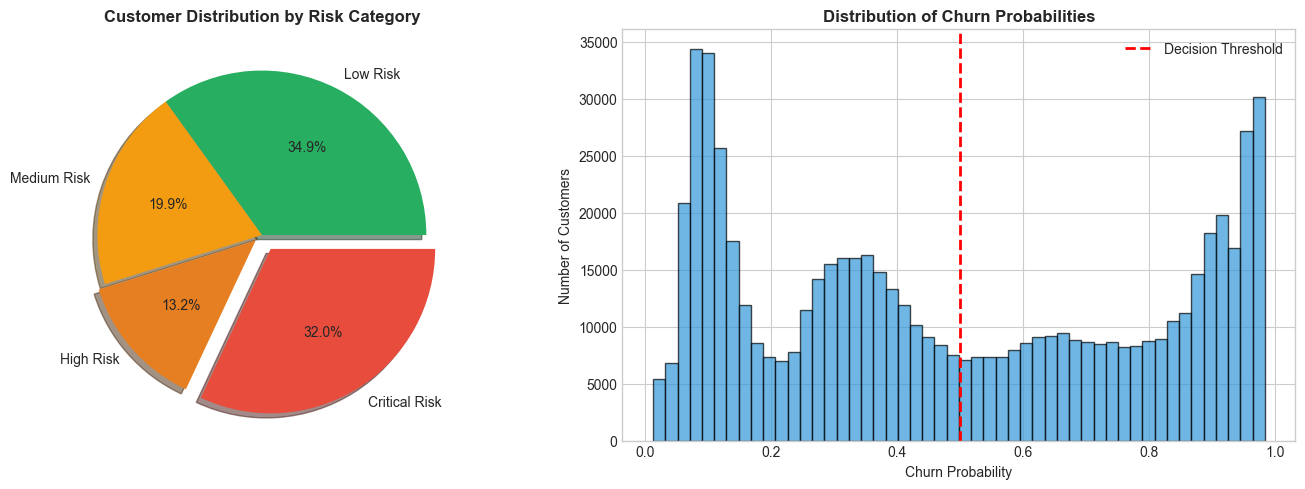


💡 Actionable Insights:
   • 290,192 customers (45.2%) identified as High/Critical Risk
   • These customers should be prioritised for retention campaigns
   • Estimated churn reduction potential: Based on intervention effectiveness


In [69]:
# Customer Risk Scoring
print("=" * 60)
print("CUSTOMER RISK SCORING DEMONSTRATION")
print("=" * 60)

# Use the best performing model to score all customers
customer_scores = model_df_dummies.copy()
customer_scores['churn_probability'] = rf_model.predict_proba(X)[:, 1]
customer_scores['risk_category'] = pd.cut(customer_scores['churn_probability'], 
                                          bins=[0, 0.3, 0.5, 0.7, 1.0],
                                          labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk'])

# Summary by risk category
risk_summary = customer_scores.groupby('risk_category').agg({
    'churned': ['count', 'sum', 'mean']
}).round(4)
risk_summary.columns = ['Customer Count', 'Actually Churned', 'Actual Churn Rate']

print("\n📊 Customer Risk Distribution:")
print("-" * 60)
print(risk_summary.to_string())

# Visualise risk distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk category distribution
risk_counts = customer_scores['risk_category'].value_counts().sort_index()
colors = ['#27ae60', '#f39c12', '#e67e22', '#e74c3c']
axes[0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
            colors=colors, explode=(0, 0, 0.05, 0.1), shadow=True)
axes[0].set_title('Customer Distribution by Risk Category', fontweight='bold')

# Churn probability distribution
axes[1].hist(customer_scores['churn_probability'], bins=50, color='#3498db', 
             edgecolor='black', alpha=0.7)
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1].set_xlabel('Churn Probability')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Distribution of Churn Probabilities', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n💡 Actionable Insights:")
high_risk_count = (customer_scores['risk_category'].isin(['High Risk', 'Critical Risk'])).sum()
total_customers = len(customer_scores)
print(f"   • {high_risk_count:,} customers ({high_risk_count/total_customers*100:.1f}%) identified as High/Critical Risk")
print(f"   • These customers should be prioritised for retention campaigns")
print(f"   • Estimated churn reduction potential: Based on intervention effectiveness")


In [70]:
# Final Summary Statistics
print("=" * 70)
print("                      ANALYSIS SUMMARY")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                        DATA SUMMARY                                  │
├─────────────────────────────────────────────────────────────────────┤
│  Total Bookings Analysed:         {len(df):>10,}                          │
│  Unique Customers:                {len(customer_df):>10,}                          │
│  Overall Churn Rate:              {df['churn_flag'].mean()*100:>10.2f}%                        │
│  Date Range:                      {df['bk_date'].min()} to {df['bk_date'].max()}       │
├─────────────────────────────────────────────────────────────────────┤
│                        MODEL PERFORMANCE                             │
├─────────────────────────────────────────────────────────────────────┤
│  Best Model:                      Random Forest                      │
│  ROC-AUC Score:                   {roc_auc_score(y_test, y_prob_rf):>10.4f}                        │
│  Accuracy:                        {accuracy_score(y_test, y_pred_rf):>10.4f}                        │
├─────────────────────────────────────────────────────────────────────┤
│                        KEY DRIVERS OF CHURN                          │
├─────────────────────────────────────────────────────────────────────┤
│  1. Customer Type (New vs Existing)                                  │
│  2. Loyalty Tier (Non-member vs Member)                              │
│  3. Cancellation Behaviour                                           │
│  4. Website Engagement (Visit duration, pages viewed)                │
│  5. Number of Previous Bookings                                      │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n✅ Analysis Complete - Ready for presentation to leadership team")


                      ANALYSIS SUMMARY

┌─────────────────────────────────────────────────────────────────────┐
│                        DATA SUMMARY                                  │
├─────────────────────────────────────────────────────────────────────┤
│  Total Bookings Analysed:            689,742                          │
│  Unique Customers:                   642,373                          │
│  Overall Churn Rate:                   44.41%                        │
│  Date Range:                      2018-06-01 to 2019-07-31       │
├─────────────────────────────────────────────────────────────────────┤
│                        MODEL PERFORMANCE                             │
├─────────────────────────────────────────────────────────────────────┤
│  Best Model:                      Random Forest                      │
│  ROC-AUC Score:                       0.8668                        │
│  Accuracy:                            0.7875                        │
├──────────────────